# Initialization

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr

import ipywidgets as widgets
import xgcm

from numpy import pi as π

import sys

import ipywidgets as widgets
# sys.path.append('../analysis/')
# # m6toolbox is a python package that has a function that helps visualize vertical sections
# import m6toolbox

# sys.path.insert(0, '../pittwolfe')
import pittwolfe as pw
# from pittwolfe.util import sind, cosd

# latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
# lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)

In [3]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()

client = Client(cluster)
client

/Users/cwolfe/mambaforge/envs/py310/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65506 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65506/status,
Dashboard: http://127.0.0.1:65506/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65507,Workers: 4
Dashboard: http://127.0.0.1:65506/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:65532,Total threads: 4
Dashboard: http://127.0.0.1:65533/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:65513,


# Specify the experiment

In [5]:
# expdir = '../2layer/flat/25km_newsponge'
# expdir = '../2layer/flat/25km'
# expdir = '../2layer/flat/25km_faster_sponge'
expdir = '../2layer/flat/25km_dt3600_uv_sponge'

# expdir = '../2layer/flat/5km_dt600'
# expdir = '../2layer/flat/5km_test'
# expdir = '../2layer/flat/5km_dt0540'

# Load data

In [6]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

In [7]:
g = 9.8

try:
    grid.close()
except:
    pass

grid = xr.open_dataset(os.path.join(expdir, 'static.nc'))
grid.close()

ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v})
ic.close()
grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

ρ0 = float(grid.zl.isel(zl=0))
grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

Lx = float(grid.dxT.isel(yh=0).sum('xh'))/1e3
Ly = float(grid.dyT.isel(xh=0).sum('yh'))/1e3

grid

<xarray.Dataset>
Dimensions:      (xh: 320, yh: 120, time: 1, xq: 321, yq: 121, zi: 3, zl: 2)
Coordinates:
  * xh           (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yh           (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * time         (time) object 0001-01-01 00:00:00
  * xq           (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq           (yq) float64 -1.5e+03 -1.475e+03 ... 1.475e+03 1.5e+03
    Time         timedelta64[ns] 00:00:00
  * zi           (zi) float64 1.034e+03 1.036e+03 1.038e+03
  * zl           (zl) float64 1.035e+03 1.037e+03
Data variables: (12/19)
    area_t       (yh, xh) float32 ...
    area_u       (yh, xq) float32 ...
    area_v       (yq, xh) float32 ...
    area_q       (yq, xq) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    ...           ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dyCv         (yq, xh) float32 ...
    Idamp_u      (yh, xq) float32 ...
    Idamp_v      (yq, xh) float32 ...
    gprime       (zl) float64 9.8 0.01855
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [8]:
real_ic = xr.open_dataset(os.path.join(expdir, 'INPUT/jet_ic.nc'))
real_ic

<xarray.Dataset>
Dimensions:  (yh: 120, xq: 321, yq: 121, xh: 320, zl: 2, zi: 3)
Coordinates:
  * yh       (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * xq       (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq       (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * xh       (xh) float64 12.5 37.5 62.5 87.5 ... 7.938e+03 7.962e+03 7.988e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    Idamp_u  (yh, xq) float64 ...
    Idamp_v  (yq, xh) float64 ...
    u        (zl, yh, xq) float64 ...
    v        (zl, yq, xh) float64 ...
    eta      (zi, yh, xh) float64 ...

In [9]:
grid_op = xgcm.Grid(grid, periodic=['X'], coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [10]:
try:
    snap.close()
except:
    pass

snap = xr.open_mfdataset(os.path.join(expdir, 'snapshot__????.nc'), decode_times=False, chunks={'time': 1})
# prog = xr.open_dataset(os.path.join(expdir, 'prog.nc'), decode_times=False)
snap

,Array,Chunk
Bytes,211.60 MiB,300.94 kiB
Shape,"(720, 2, 120, 321)","(1, 2, 120, 321)"
Count,2 Graph Layers,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,212.70 MiB,302.50 kiB
Shape,"(720, 2, 121, 320)","(1, 2, 121, 320)"
Count,2 Graph Layers,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
try:
    prog.close()
except:
    pass

prog = xr.open_mfdataset(os.path.join(expdir, 'prog__00??.nc'), decode_times=False, chunks={'time': 1})
# prog = xr.open_dataset(os.path.join(expdir, 'prog.nc'), decode_times=False)
prog

<xarray.Dataset>
Dimensions:     (xq: 321, yh: 120, zl: 2, time: 2, nv: 2, xh: 320, yq: 121,
                 zi: 3)
Coordinates:
  * xq          (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yh          (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl          (zl) float64 1.035e+03 1.037e+03
  * time        (time) float64 180.0 540.0
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yq          (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * zi          (zi) float64 1.034e+03 1.036e+03 1.038e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 120, 320), meta=np.ndarray>
    e           (time, zi, yh, xh) float32 dask.array<chunksize=(1, 3, 120, 320), meta=np.ndarray>
    wd          (time, zi, yh, xh) float32 dask.array<chunksize=(1, 3, 120, 320), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 120, 321), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 121, 320), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [11]:
try:
    mom.close()
except:
    pass

mom = xr.open_mfdataset(os.path.join(expdir, 'mom__00??.nc'), decode_times=False, chunks={'time': 1})
mom

,Array,Chunk
Bytes,211.60 MiB,300.94 kiB
Shape,"(720, 2, 120, 321)","(1, 2, 120, 321)"
Count,2 Graph Layers,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,212.70 MiB,302.50 kiB
Shape,"(720, 2, 121, 320)","(1, 2, 121, 320)"
Count,2 Graph Layers,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [27]:
try:
    visc.close()
except:
    pass

visc = xr.open_mfdataset(os.path.join(expdir, 'visc__00??.nc'), decode_times=False, chunks={'time': 1})
# prog = xr.open_dataset(os.path.join(expdir, 'prog.nc'), decode_times=False)
visc

OSError: no files to open

In [12]:
try:
    stats.close()
except:
    pass
stats = xr.open_dataset(os.path.join(expdir, 'OUTPUT/ocean.stats.nc'), decode_times=False)
t_end = int(stats.Time[-1])
stats.close()

Nl = len(stats.Layer)
stats

<xarray.Dataset>
Dimensions:        (Layer: 2, Interface: 3, Time: 2)
Coordinates:
  * Layer          (Layer) float64 1.035e+03 1.037e+03
  * Interface      (Interface) float64 1.034e+03 1.036e+03 1.038e+03
  * Time           (Time) float64 0.0 1.0
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  OUTPUT/ocean.stats.nc

Text(0.5, 0, 'time [years]')

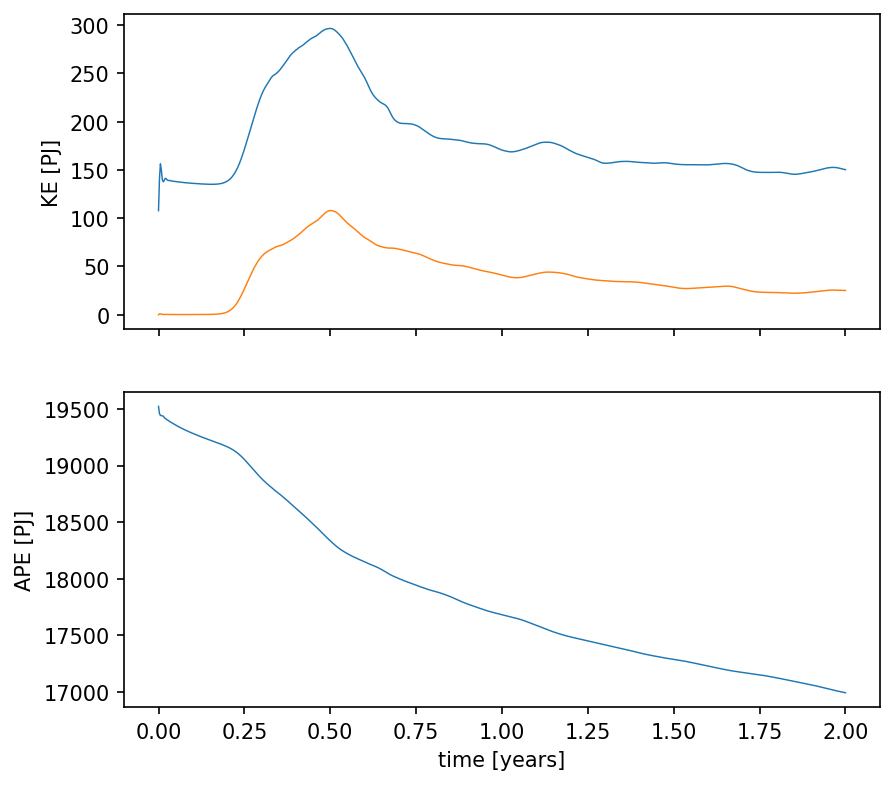

In [13]:
years = stats.Time/360

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5, 6))

ax = axs[0]
for zl in range(Nl):
    ax.plot(years, stats.KE.isel(Layer=zl)/1e15, label='layer ' + str(zl+1), lw=.7)
# ax.legend()
ax.set_ylabel('KE [PJ]')

ax = axs[1]
for zi in range(1,Nl):
    ax.plot(years, stats.APE.isel(Interface=zi)/1e15, label='interface ' + str(zi), lw=.7)
# ax.legend()
ax.set_ylabel('APE [PJ]')
ax.set_xlabel('time [years]')

# savefig(fig, 'energy')

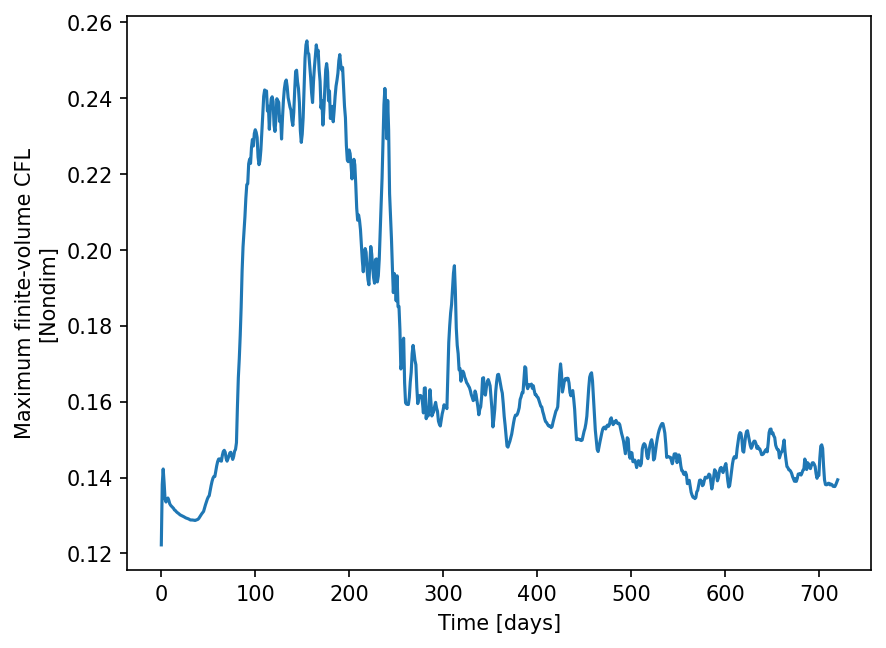

In [14]:
stats.max_CFL_trans.plot()

# Snapshots

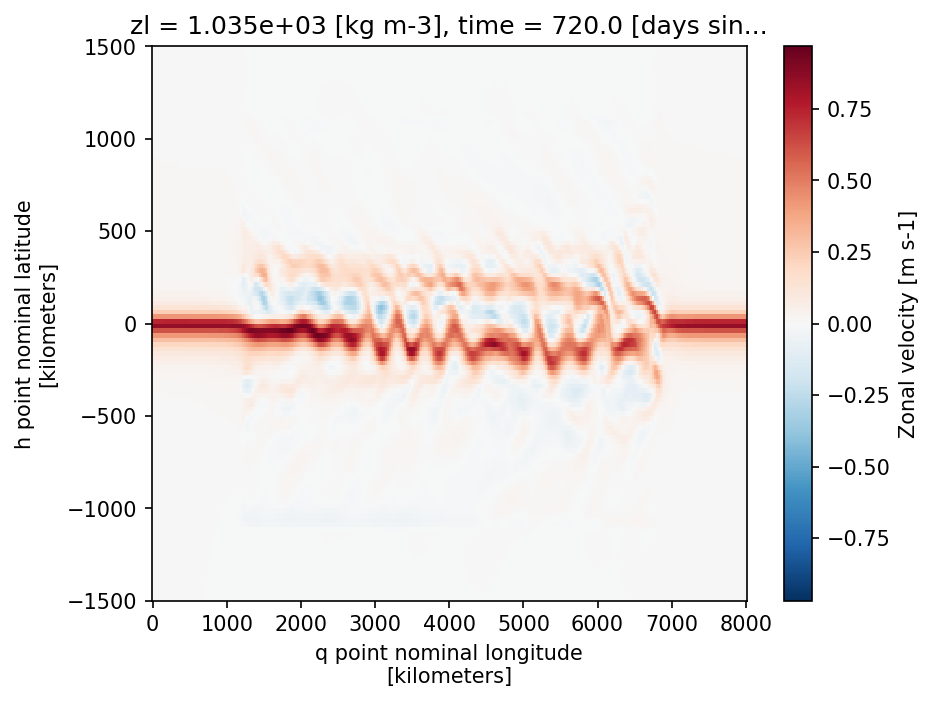

In [13]:
snap.u.isel(zl=0,time=-1).plot()
# plt.gca().set_aspect(1)

## Trying to figure out if the relaxation is working

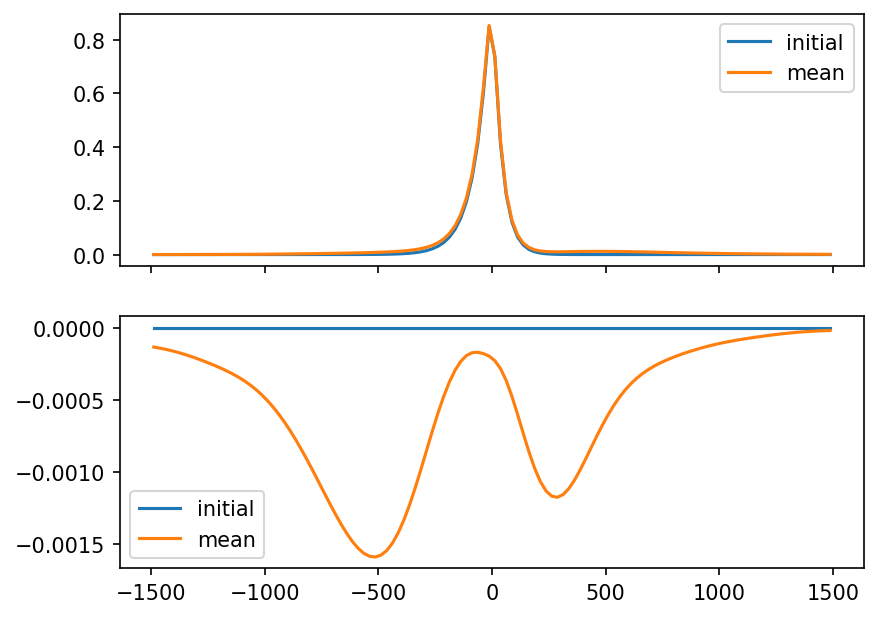

In [15]:
fig, axs = plt.subplots(nrows=2, sharex=True)

ax = axs[0]
ax.plot(grid.yh, ic.u.isel(zl=0).sel(xq=900, method='nearest'), label='initial')
ax.plot(grid.yh, prog.u.isel(zl=0,time=-1).sel(xq=900, method='nearest'), label='mean')
# ax.set_xlim(-300, 300)
ax.legend()

ax = axs[1]
ax.plot(grid.yh, ic.u.isel(zl=1).sel(xq=900, method='nearest'), label='initial')
ax.plot(grid.yh, prog.u.isel(zl=1,time=-1).sel(xq=900, method='nearest'), label='mean')
# ax.set_xlim(-300, 300)
ax.legend()

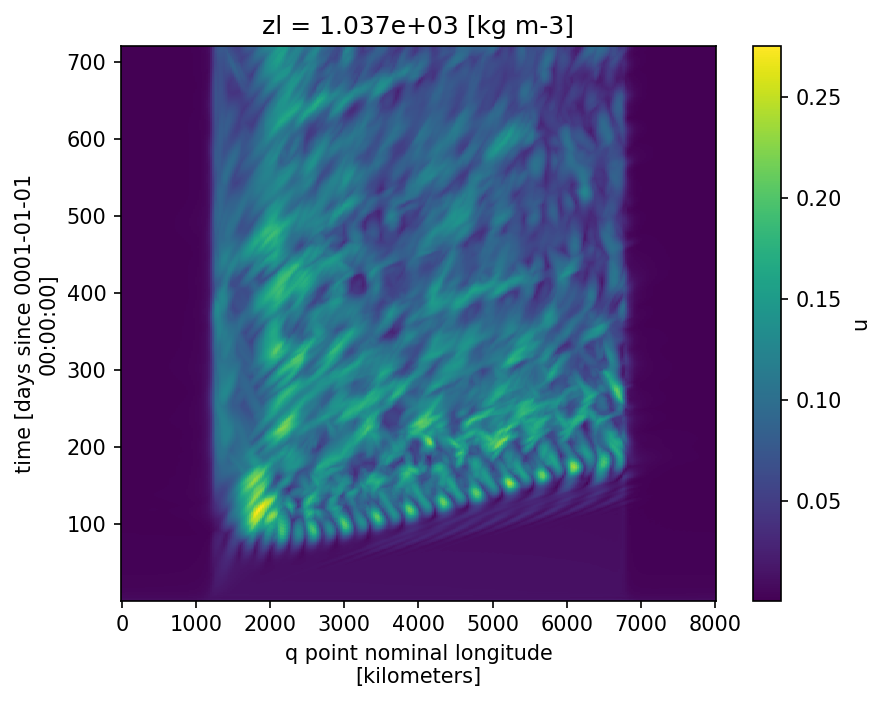

In [16]:
np.abs(snap.u.isel(zl=1)).max('yh').plot()

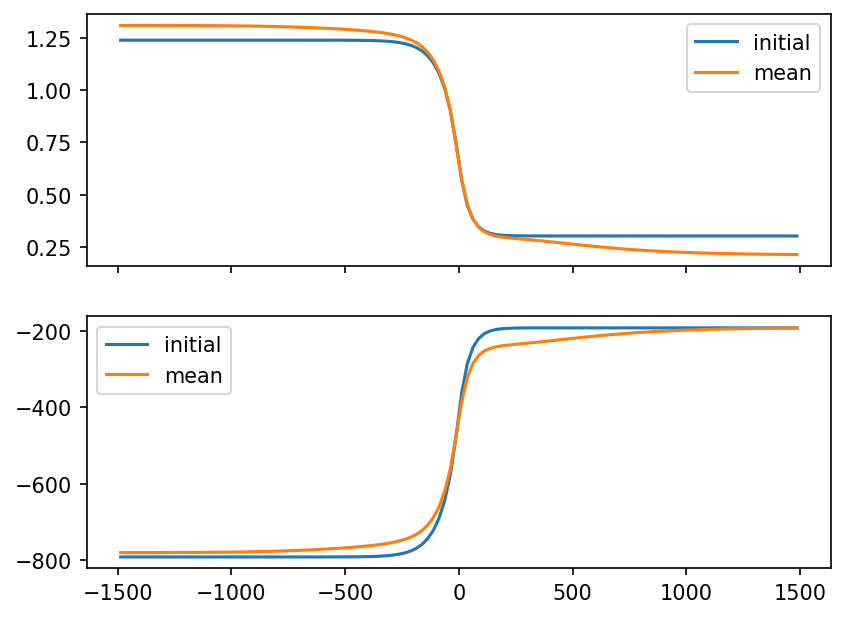

In [20]:
fig, axs = plt.subplots(nrows=2, sharex=True)

for k in range(2):
    ax = axs[k]
    ax.plot(grid.yh, ic.eta.isel(zi=k).sel(xh=900, method='nearest'), label='initial')
    ax.plot(grid.yh, prog.e.isel(zi=k,time=-1).sel(xh=900, method='nearest'), label='mean')
    # ax.set_xlim(-300, 300)
    ax.legend()


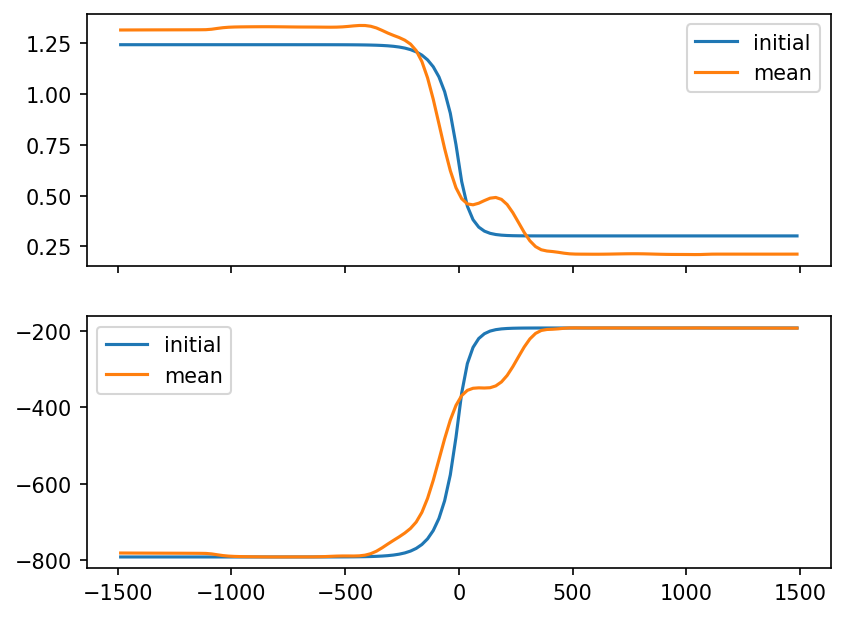

In [39]:
fig, axs = plt.subplots(nrows=2, sharex=True)

for k in range(2):
    ax = axs[k]
    ax.plot(grid.yh, ic.eta.isel(zi=k).sel(xh=3000, method='nearest'), label='initial')
    ax.plot(grid.yh, prog.e.isel(zi=k,time=-1).sel(xh=3000, method='nearest'), label='mean')
    # ax.set_xlim(-300, 300)
    ax.legend()


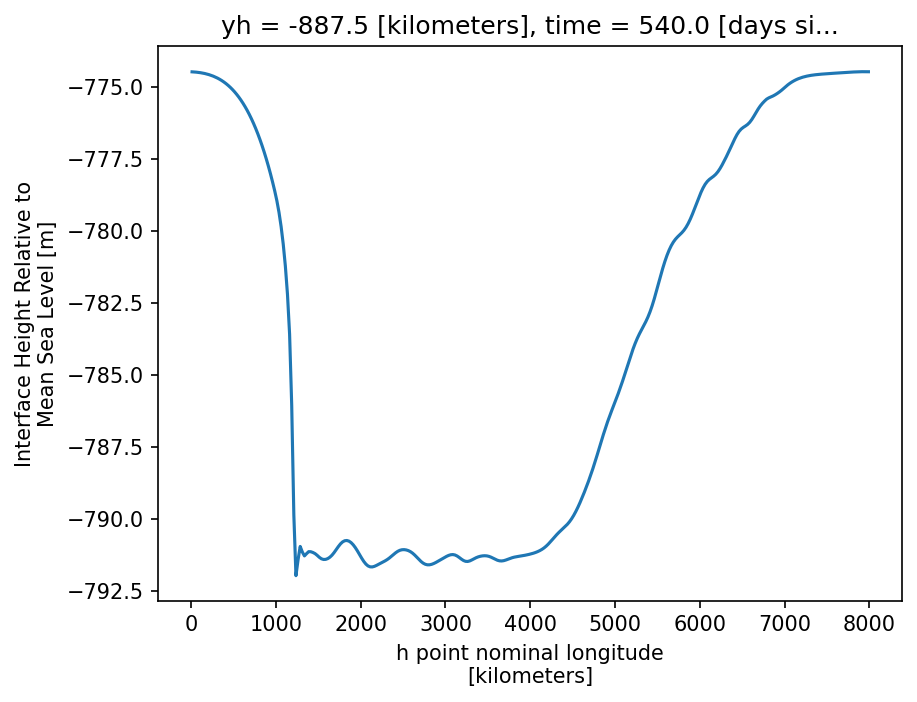

In [40]:
prog.e.isel(zi=1, time=-1).sel(yh=-900, method='nearest').plot()

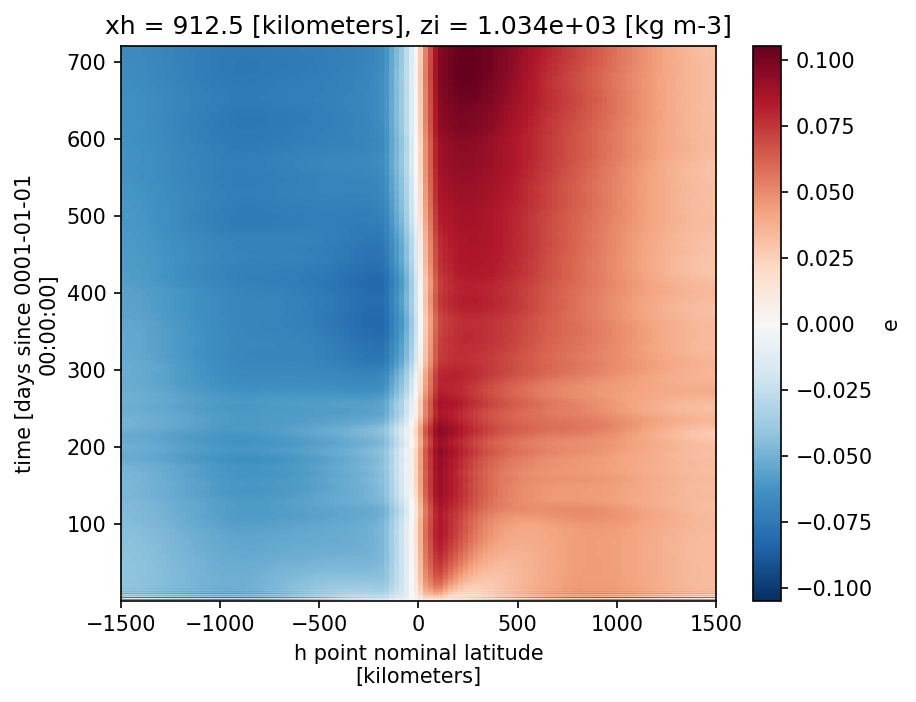

In [22]:
(snap.e.isel(zi=0) - snap.e.isel(zi=0,time=0)).sel(xh=900, method='nearest').plot()

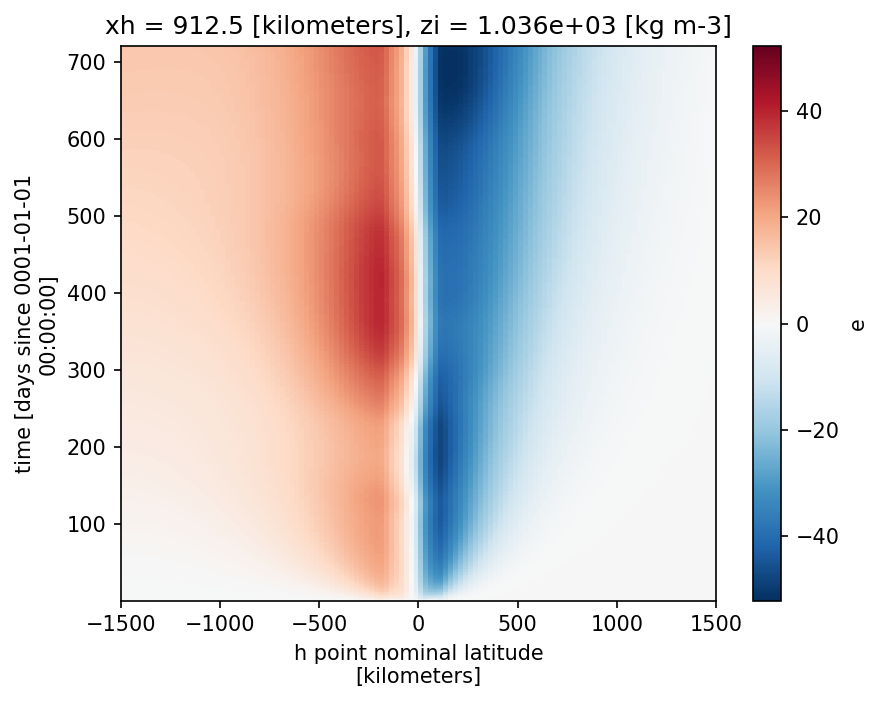

In [25]:
(snap.e.isel(zi=1) - snap.e.isel(zi=1,time=0)).sel(xh=900, method='nearest').plot()

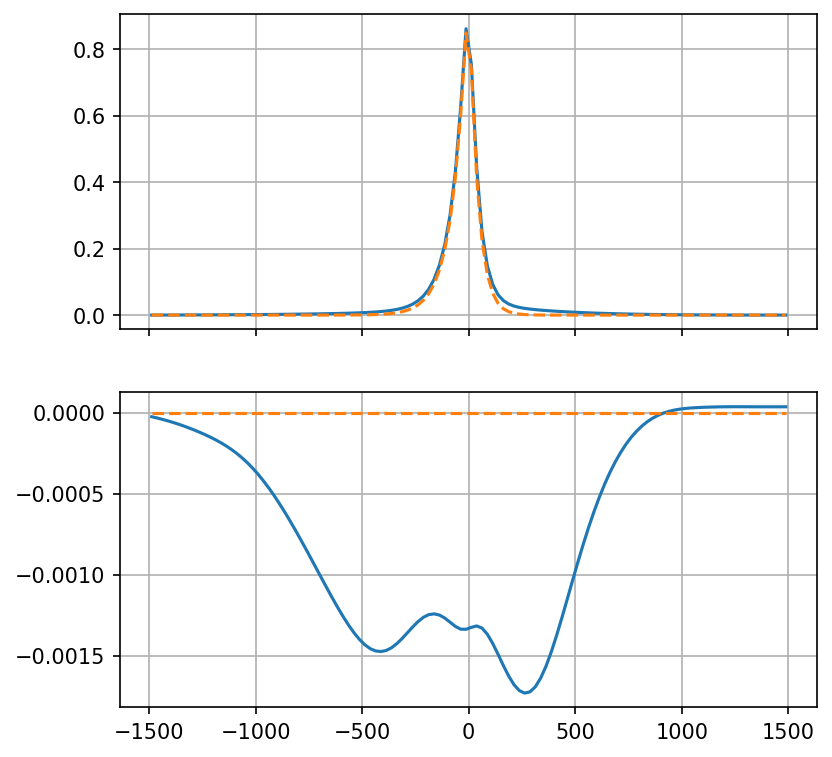

In [26]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

for zl in range(2):
    for t in range(0, len(prog.time), 360):
        axs[zl].plot(grid.yh, prog.u.isel(zl=zl,time=t).sel(xq=900, method='nearest'))
        axs[zl].plot(grid.yh, ic.u.isel(zl=zl).sel(xq=900, method='nearest'), '--')
    axs[zl].grid()
    
fig.savefig(os.path.join(expdir, 'u900.pdf'), bbox_inches='tight')

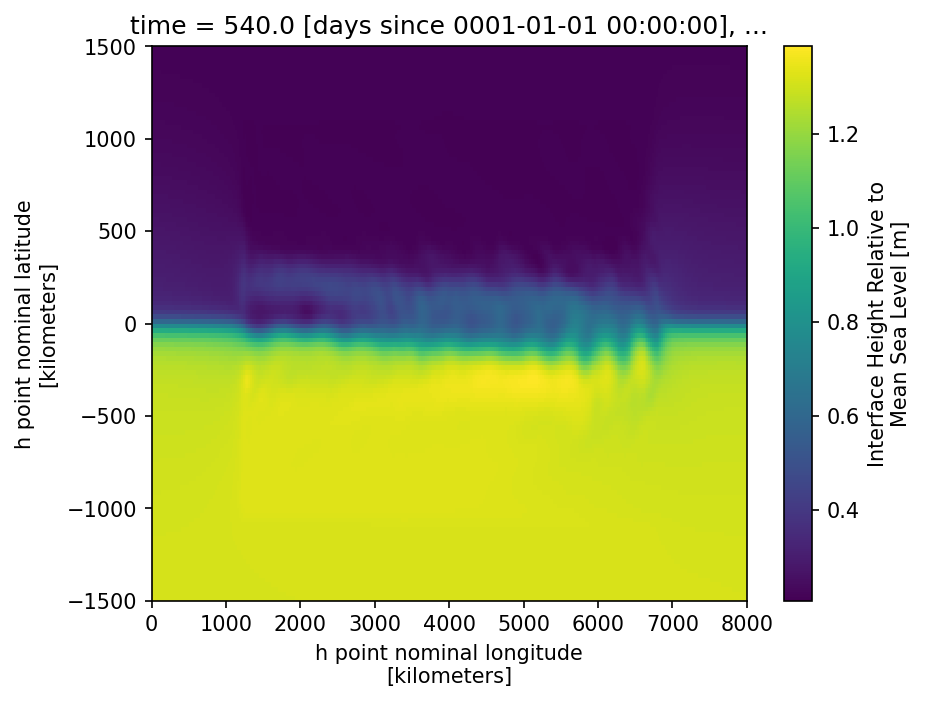

In [27]:
prog.e.isel(zi=0,time=-1).plot()

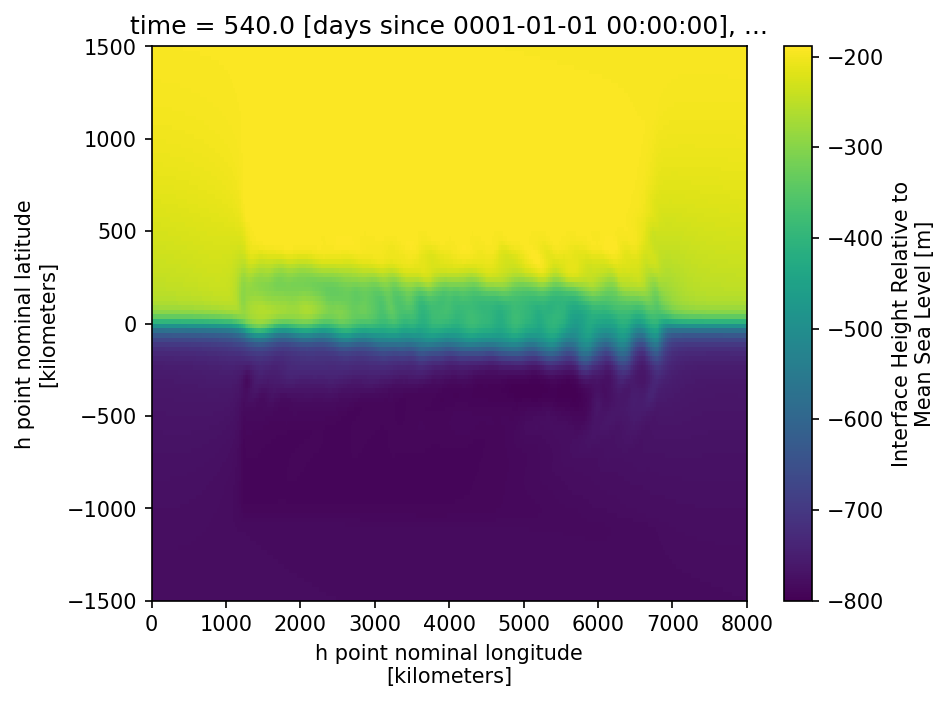

In [28]:
prog.e.isel(zi=1,time=-1).plot()

# Means

In [31]:
time_mean = slice(-5, None)

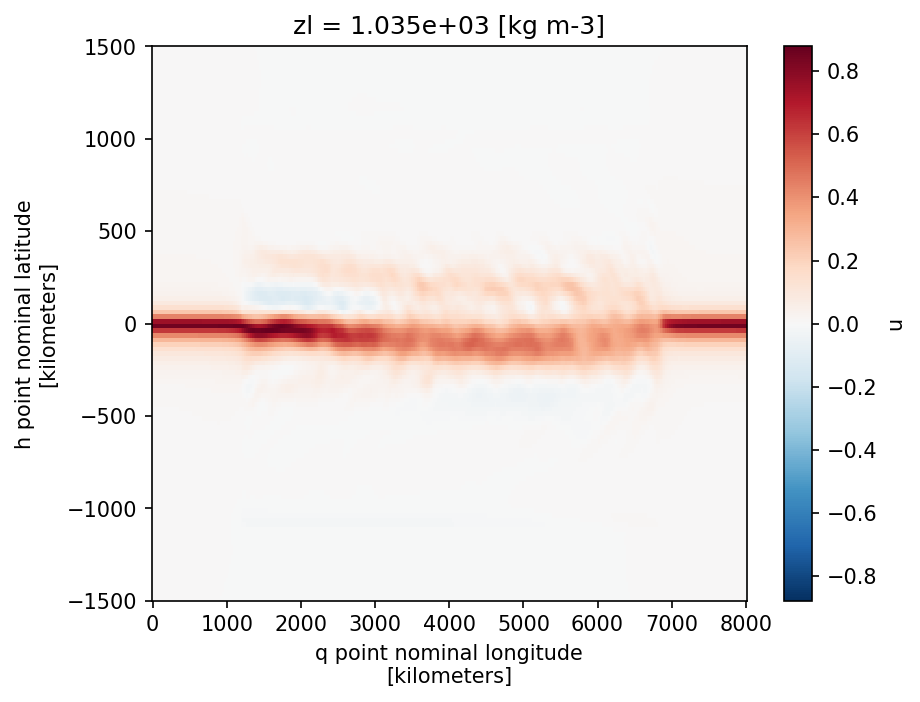

In [32]:
prog.u.isel(zl=0, time=time_mean).mean('time').plot()

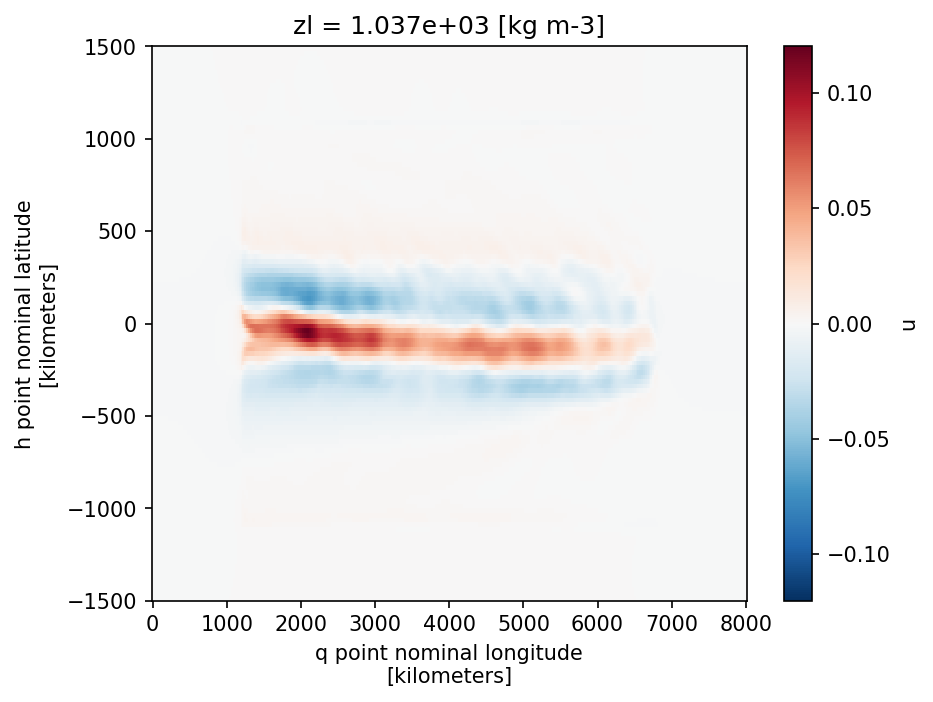

In [33]:
prog.u.isel(zl=1, time=time_mean).mean('time').plot()

## Barotropic streamfunction

In [34]:
U = prog.uh.isel(time=time_mean).mean('time').sum('zl').load()
psiB = -1e-6*grid_op.cumsum(U, 'Y', boundary='fill', fill_value=0)
psiB = psiB - psiB.isel(yq=-1).mean()/2

In [35]:
recirc_pos_south = psiB.argmax(dim=('xq', 'yq'))
recirc_pos_north = psiB.argmin(dim=('xq', 'yq'))

recirc_x_south = float(psiB.xq.isel(xq=int(recirc_pos_south['xq'])))
recirc_x_north = float(psiB.xq.isel(xq=int(recirc_pos_north['xq'])))

recirc_x = (recirc_x_south + recirc_x_north)/2

recirc_y_south = float(psiB.yq.isel(yq=int(recirc_pos_south['yq'])))
recirc_y_north = float(psiB.yq.isel(yq=int(recirc_pos_north['yq'])))

In [36]:
psiB_N = psiB.isel(yq= 0).mean('xq')
psiB_S = psiB.isel(yq=-1).mean('xq')

recirc_north = float(psiB_S - psiB.min())
recirc_south = float(psiB.max() - psiB_N)

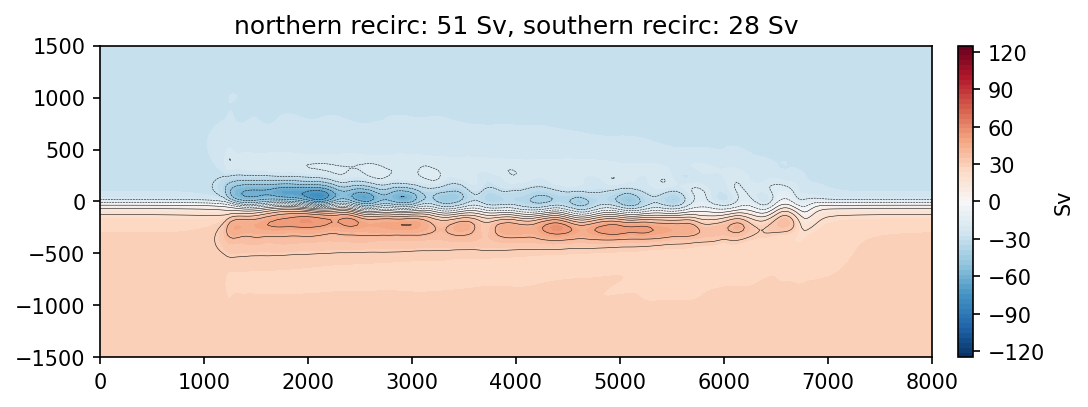

In [38]:
fig, ax = plt.subplots(figsize=(9, 2.7))

vmax = 125
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(psiB.xq, psiB.yq, psiB, levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ticks=np.arange(-120, 120+1, 30), label='Sv', pad=0.025)
ax.contour(psiB.xq, psiB.yq, psiB, levels=np.arange(-120, 120+1, 10), colors='k', linewidths=.25)
# ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
# ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

ax.set_title('northern recirc: {:.0f} Sv, southern recirc: {:.0f} Sv'.format(recirc_north, recirc_south))

fig.savefig(os.path.join(expdir,'streamfunction.pdf'), bbox_inches='tight')

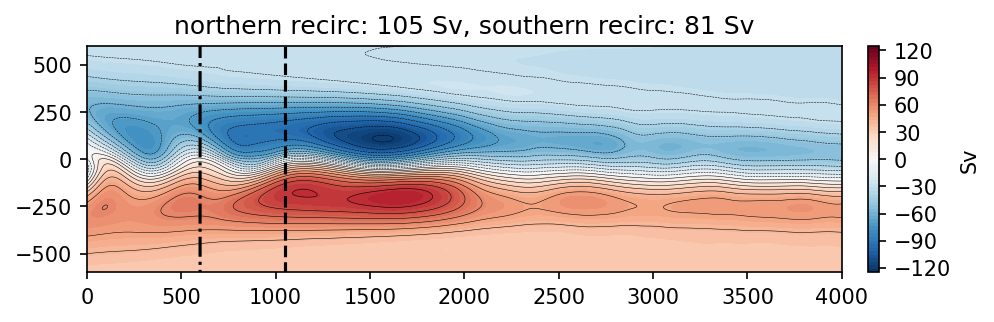

In [261]:
fig, ax = plt.subplots(figsize=(9, 2))

vmax = 125
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(psiB.xq, psiB.yq, psiB, levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ticks=np.arange(-120, 120+1, 30), label='Sv', pad=0.025)
ax.contour(psiB.xq, psiB.yq, psiB, levels=np.arange(-120, 120+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

ax.set_aspect(1)

ax.set_title('northern recirc: {:.0f} Sv, southern recirc: {:.0f} Sv'.format(recirc_north, recirc_south))

fig.savefig(os.path.join(expdir,'streamfunction_zoom.pdf'), bbox_inches='tight')

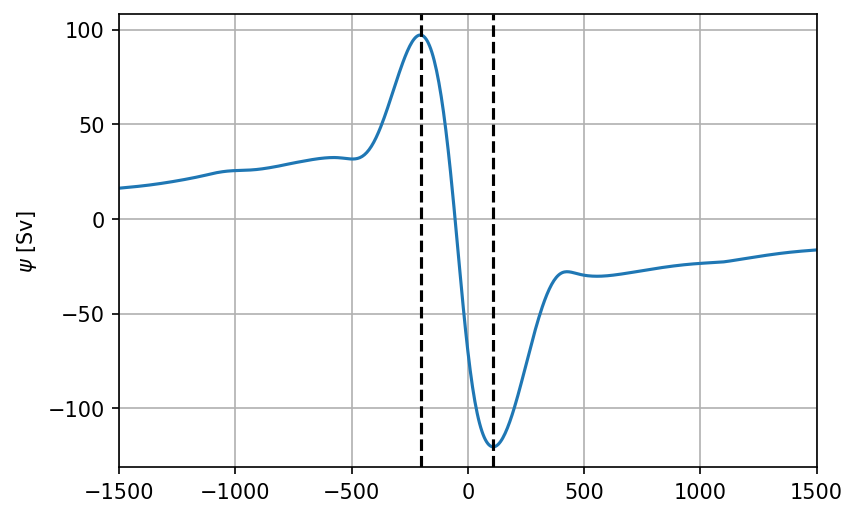

In [351]:
fig, ax = plt.subplots()

ax.plot(psiB.yq, psiB.sel(xq=recirc_x, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_xlim([-1500, 1500])
ax.set_ylabel('$\psi$ [Sv]')

fig.savefig('psiB_profile.pdf', bbox_inches='tight')

## SSH

In [262]:
ηbar = prog.e.isel(zi=slice(None, 2), time=time_mean).mean('time')

In [263]:
np.abs(ηbar).max(('xh', 'yh')).values

array([6.801243e-01, 7.967981e+02], dtype=float32)

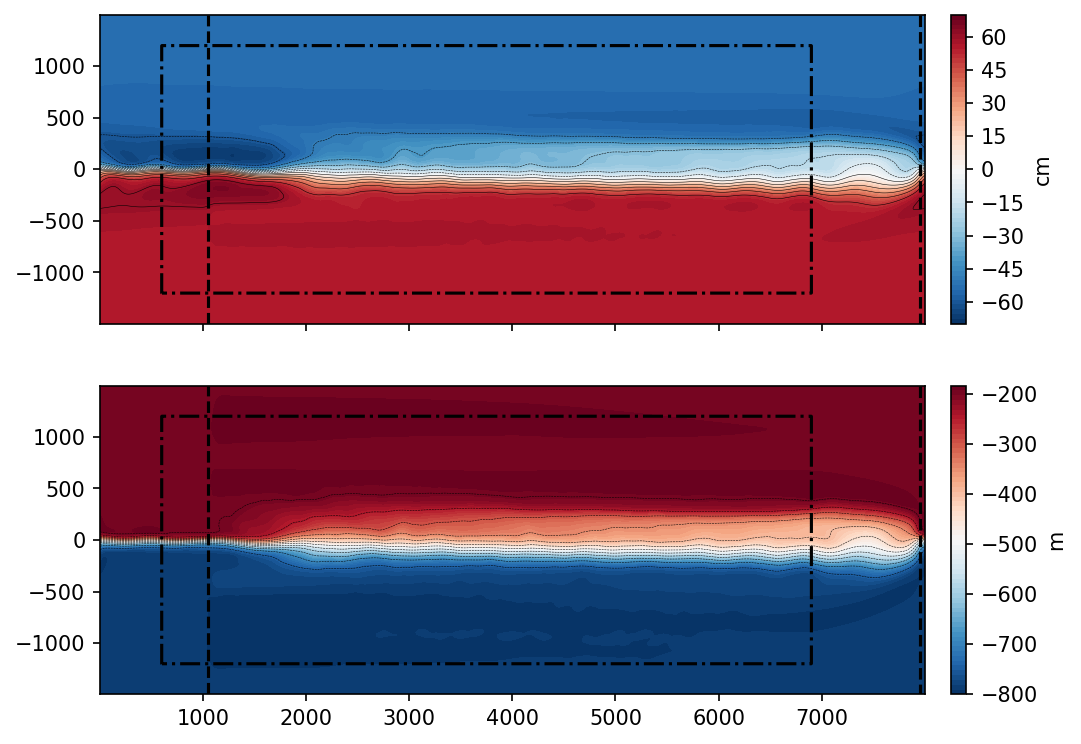

In [264]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmax = 70
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-60, 60+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(-vmax, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 10
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 10
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-800, -180+1, 50), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

fig.savefig(os.path.join(expdir,'eta.pdf'), bbox_inches='tight')

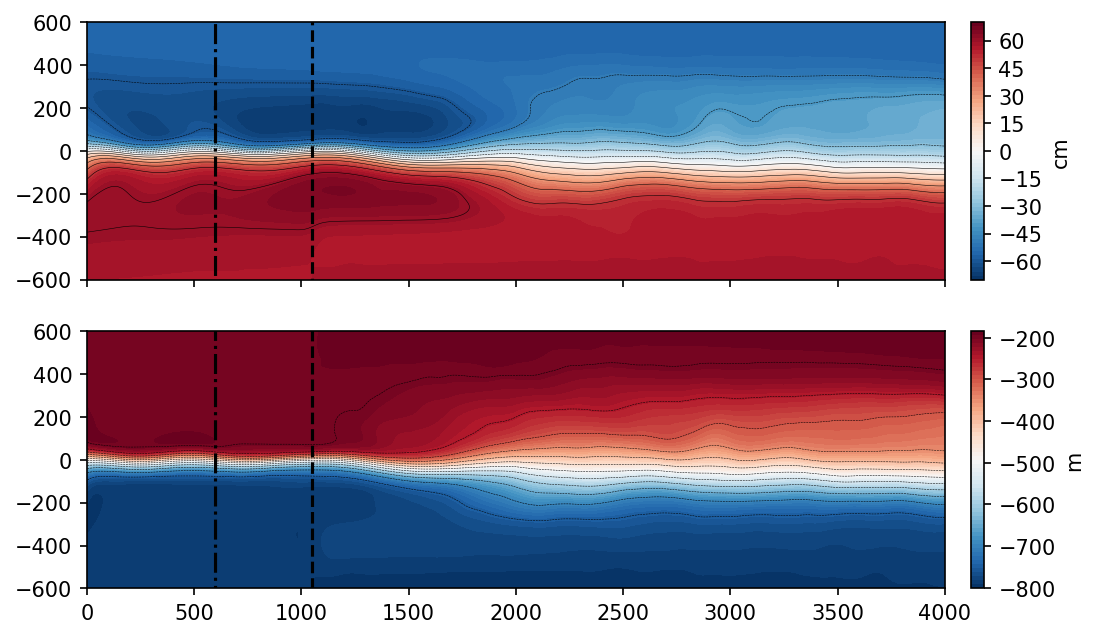

In [305]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmax = 70
levels = np.linspace(-vmax, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-60, 60+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(-vmax, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 10
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 10
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-800, -180+1, 50), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

fig.savefig(os.path.join(expdir,'eta_zoom.pdf'), bbox_inches='tight')

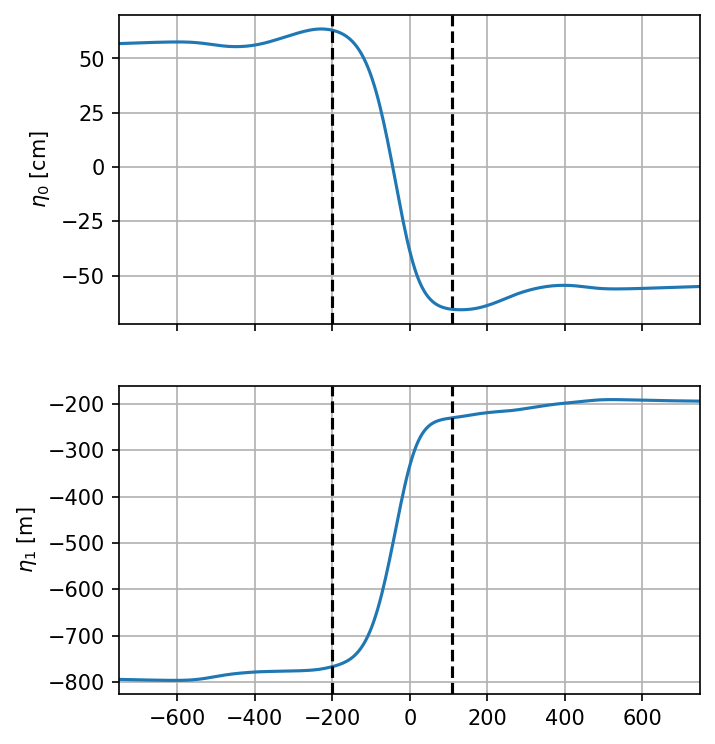

In [352]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

ax = axs[0]
ax.plot(ηbar.yh, 100*ηbar.isel(zi=0).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_0$ [cm]')

ax = axs[1]
ax.plot(ηbar.yh, ηbar.isel(zi=1).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_1$ [m]')

ax.set_xlim([-750, 750])
fig.savefig('eta_profile.pdf', bbox_inches='tight')

## TWA vorticity

In [266]:
uh = prog.uh.isel(time=time_mean).mean('time').load()
vh = prog.vh.isel(time=time_mean).mean('time').load()
hbar = prog.h.isel(time=time_mean).mean('time').load()

In [267]:
hu = grid_op.interp(hbar, 'X')
hv = grid_op.interp(hbar, 'Y')
hq = grid_op.interp(hv, 'X')

uhat = uh/hu/grid.dyCu
vhat = vh/hv/grid.dxCv

zeta = (grid_op.diff(vhat*grid.dyCv, 'X') - grid_op.diff(uhat*grid.dxCu, 'Y'))/grid.Aq
Pi = (zeta + grid.f)/hq

In [293]:
fld = 1e9*Pi.isel(zl=1)

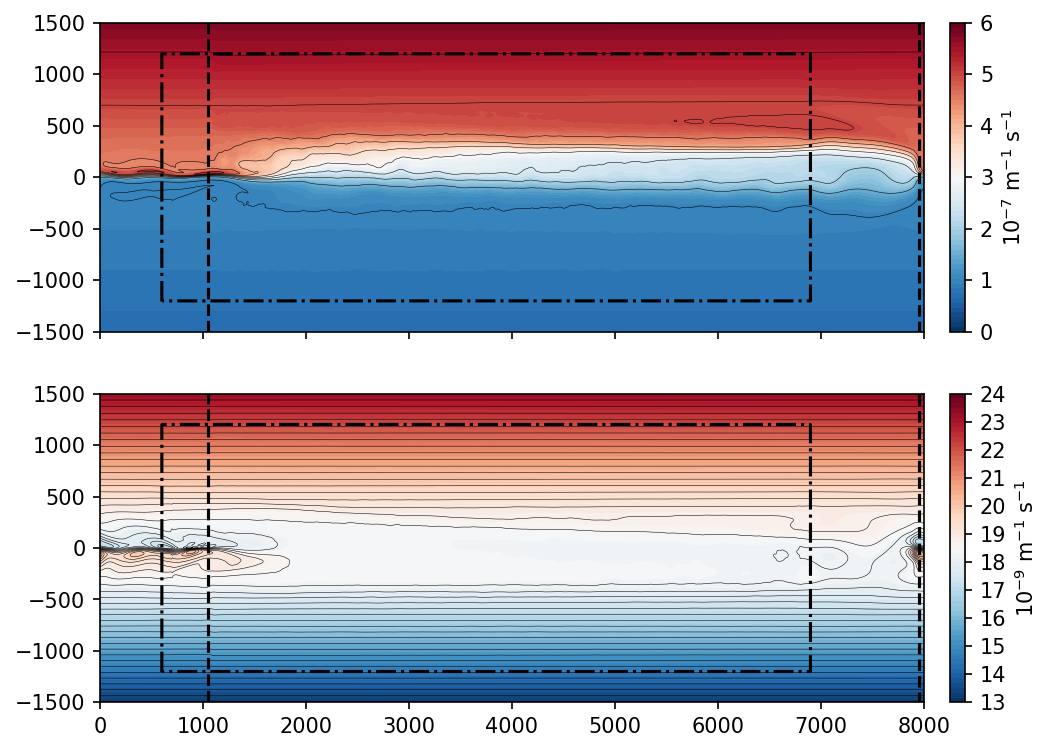

In [301]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmax = 70

fld = 1e7*Pi.isel(zl=0)

vmin = 0
vmax = 6
levels = np.linspace(vmin, vmax, 65)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmin = 13
vmax = 24
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

fig.savefig(os.path.join(expdir,'PV.pdf'), bbox_inches='tight')

In [310]:
fld = 1e9*Pi.isel(zl=1).sel(yq=slice(-600, 600))

In [358]:
recirc_x

1615.0

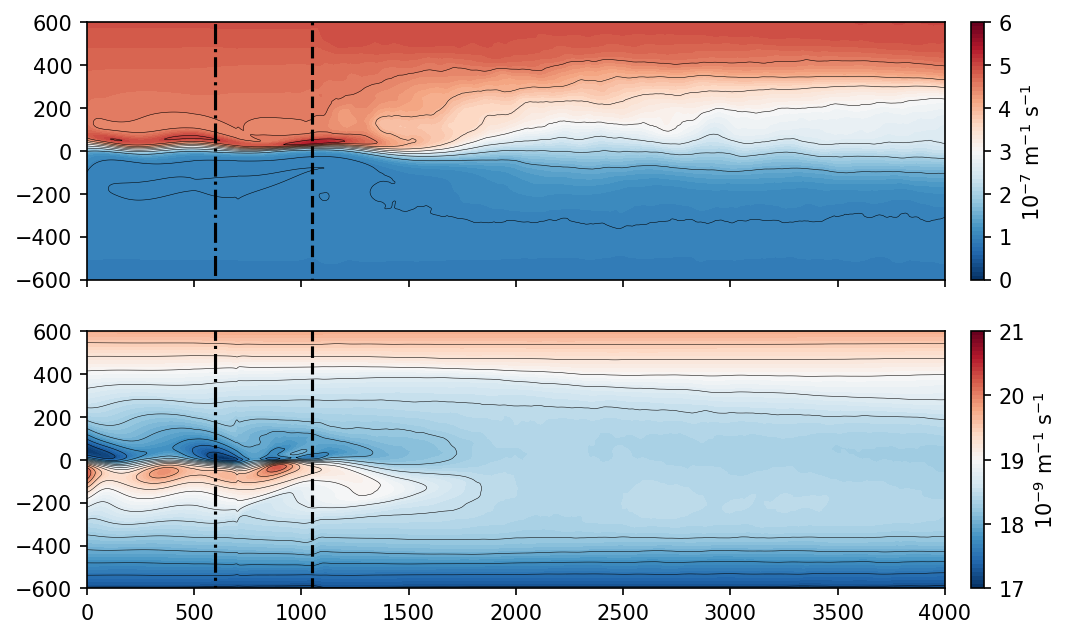

In [313]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmax = 70

fld = 1e7*Pi.isel(zl=0)

vmin = 0
vmax = 6
levels = np.linspace(vmin, vmax, 65)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmin = 17
vmax = 21
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(grid.xh, grid.yh, real_ic.Idamp, [.5*float(real_ic.Idamp.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(0, 4000)

fig.savefig(os.path.join(expdir,'PV_zoom.pdf'), bbox_inches='tight')

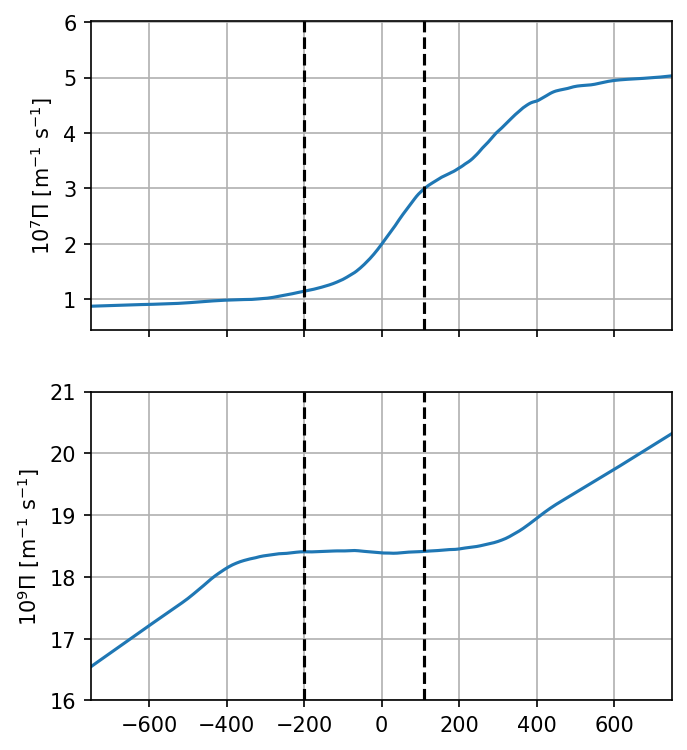

In [359]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

ax = axs[0]
fld = 1e7*Pi.isel(zl=0)
ax.plot(fld.yq, fld.sel(xq=recirc_x+500, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{7}\Pi$ [m$^{-1}$ s$^{-1}$]')

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)
ax.plot(fld.yq, fld.sel(xq=recirc_x+500, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{9}\Pi$ [m$^{-1}$ s$^{-1}$]')
ax.set_ylim(16, 21)

ax.set_xlim([-750, 750])
fig.savefig('PV_profile.pdf', bbox_inches='tight')

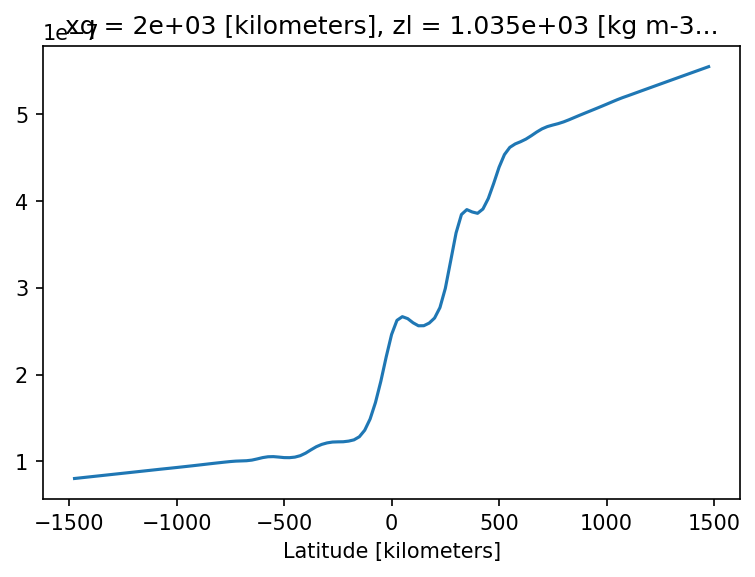

In [122]:
Pi.isel(zl=0).sel(xq=2000, method='nearest').plot()

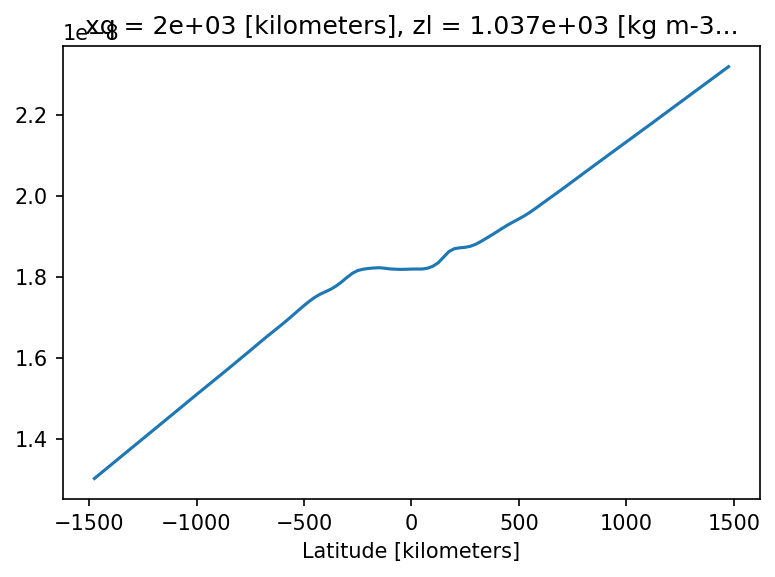

In [123]:
Pi.isel(zl=1).sel(xq=2000, method='nearest').plot()

# Close everything

In [17]:
prog.close()
grid.close()
stats.close()
ic.close()
mom.close()

try:
    client.close()
    cluster.close()
except:
    pass

NameError: name 'stats' is not defined

In [20]:
ic.close()

In [4]:

client.close()
cluster.close()

In [55]:
ic2 = xr.open_dataset(os.path.join(expdir, 'INPUT/jet_ic.nc'))
ic2

<xarray.Dataset>
Dimensions:     (yh: 600, xh: 1600, xq: 1601, zl: 2, yq: 601, zi: 3)
Coordinates:
  * yh          (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * xh          (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * xq          (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yq          (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * zl          (zl) float64 1.035e+03 1.037e+03
  * zi          (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    Kh          (yh, xh) float64 ...
    Idamp       (yh, xh) float64 ...
    u           (zl, yh, xq) float64 ...
    v           (zl, yq, xh) float64 ...
    eta         (zi, yh, xh) float64 ...
    eta_target  (zi, yh, xh) float64 ...

In [85]:
np.abs(grid.xh-900)

<xarray.DataArray 'xh' (xh: 1600)>
array([ 897.5,  892.5,  887.5, ..., 7087.5, 7092.5, 7097.5])
Coordinates:
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
    Time     timedelta64[ns] 00:00:00

In [86]:
np.argmin(np.abs(grid.xh-900).values)

179

In [87]:
ANGSTROM = 1e-10
i = 179
depth_tot = grid.D.isel(xh=i).values

eta_ref = ic2.eta_target.isel(xh=i).values
h = snap.h.isel(time=-1).isel(xh=i).values
damp = ic2.Idamp.isel(xh=i).values

In [88]:
e0 = 0
e = np.zeros_like(eta_ref)

e[1] = e[0] - h[0]
e[2] = e[1] - h[1]
e_str = e[-1]/eta_ref[-1]

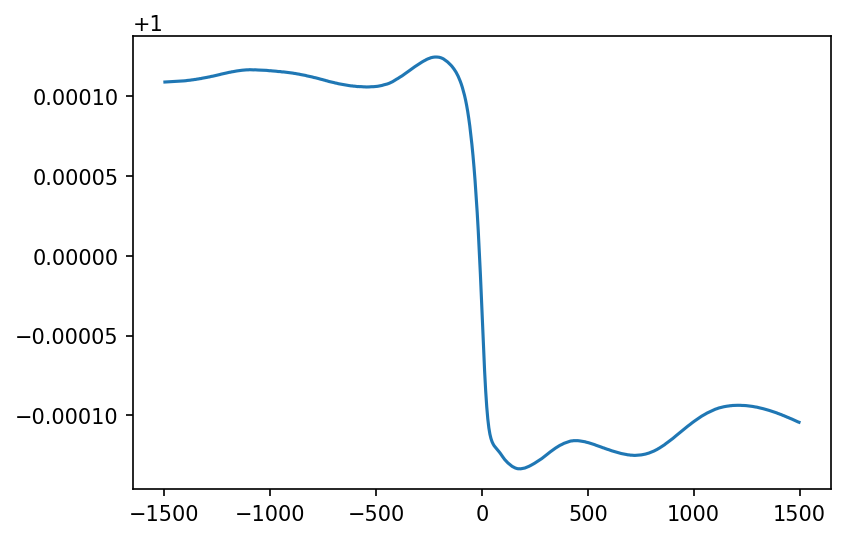

In [89]:
plt.plot(grid.yh, e_str)

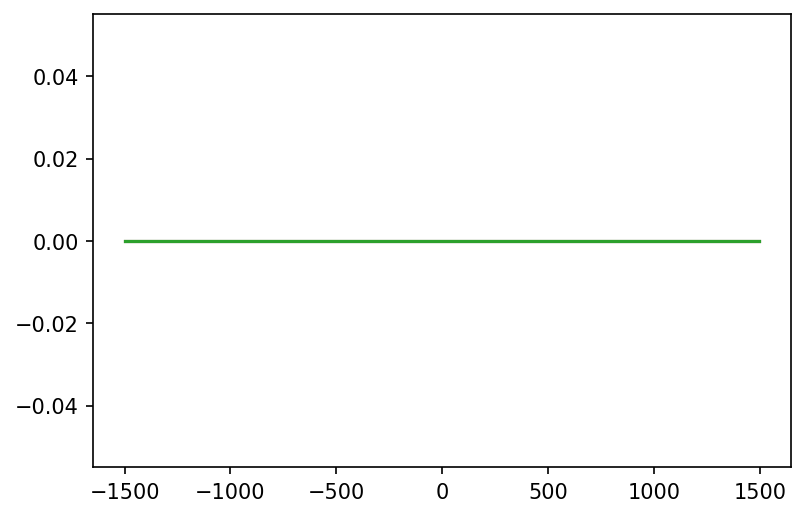

In [100]:
wpb = np.zeros(Ny)
eb = np.zeros((2, Ny))
ea = np.zeros((2, Ny))

k = 1
w = (e[k]-e0 - e_str*eta_ref[k])*damp
wm = (w - np.abs(w))/2

eb[k] = wpb
ea[k] = -wm

wpb = w - wm

k = 0

w = (e[k]-e0 - e_str*eta_ref[k])*damp
wm = (w - np.abs(w))/2

eb[k] = wpb
ea[k] = -wm

wpb = w - wm


# plt.plot(grid.yh, )
plt.plot(grid.yh, e_str*eta_ref[k])
plt.plot(grid.yh, wm)
plt.plot(grid.yh, wpb)


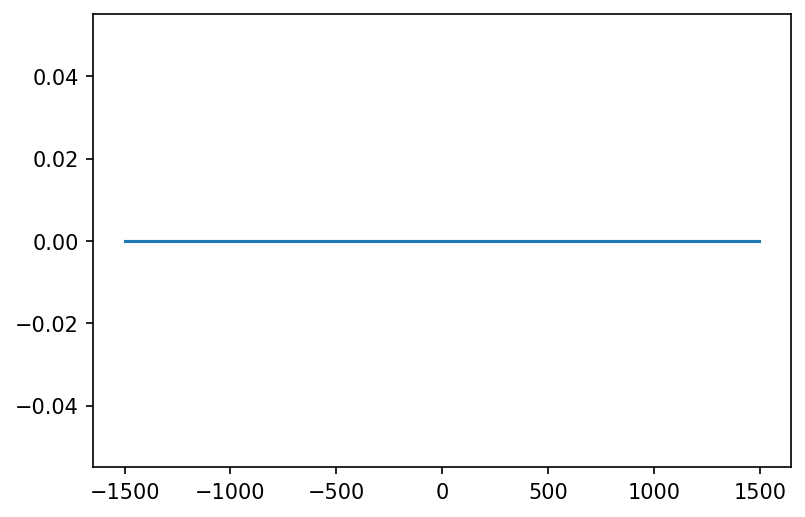

In [104]:
plt.plot(grid.yh, ea[0])

In [105]:
ic2.close()

In [137]:
40203.214777/3600

11.167559660277778

In [138]:
12*360

4320

In [139]:
26*360

9360